# Lending Club Data

The Lending Club is a platform which allows the crowdfunding of various loans. Various investors are able to browse the profiles of people applying for loans and decide whether or not to help fun them.




### Library Imports 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import time 
import seaborn as sn 



### Loading the Data 

In [408]:
df_accepted = pd.read_csv("accepted.csv")
df_rejected = pd.read_csv("rejected.csv")


/Users/lancelot/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [409]:
print(df_rejected.shape)
df_rejected.head().T

(27648741, 9)


,0,1,2,3,4
Amount Requested,1000,1000,11000,6000,1500
Application Date,2007-05-26,2007-05-26,2007-05-27,2007-05-27,2007-05-27
Loan Title,Wedding Covered but No Honeymoon,Consolidating Debt,Want to consolidate my debt,waksman,mdrigo
Risk_Score,693,703,715,698,509
Debt-To-Income Ratio,10%,10%,10%,38.64%,9.43%
Zip Code,481xx,010xx,212xx,017xx,209xx
State,NM,MA,MD,MA,MD
Employment Length,4 years,< 1 year,1 year,< 1 year,< 1 year
Policy Code,0,0,0,0,0


In [410]:
print(df_accepted.shape)
df_accepted.head().T

(2260701, 151)


,0,1,2,3,4
id,68407277,68355089,68341763,66310712,68476807
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,3600,24700,20000,35000,10400
funded_amnt,3600,24700,20000,35000,10400
funded_amnt_inv,3600,24700,20000,35000,10400
...,...,...,...,...,...
settlement_status,NaN,NaN,NaN,NaN,NaN
settlement_date,NaN,NaN,NaN,NaN,NaN
settlement_amount,NaN,NaN,NaN,NaN,NaN
settlement_percentage,NaN,NaN,NaN,NaN,NaN


In [411]:
df_rejected.dtypes

Amount Requested        float64
Application Date         object
Loan Title               object
Risk_Score              float64
Debt-To-Income Ratio     object
Zip Code                 object
State                    object
Employment Length        object
Policy Code             float64
dtype: object

In [412]:
df_accepted.dtypes

id                        object
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object

### Processing ACCEPTED Data Columns

In [499]:
# Choose the rows that are similar to the rejected columns
df_accepted_stripped = df_accepted[['funded_amnt', 'settlement_date', 'title', 
                                    'fico_range_low','fico_range_high', 'dti', 
                                    'zip_code', 'addr_state', 'emp_length', 
                                    'policy_code']]

# Here, we dropped loan title since it contains multiple types of descriptions 
# and strings would be difficult to deal with in the model 

df_accepted_stripped.head(n=3)


,funded_amnt,settlement_date,title,fico_range_low,fico_range_high,dti,zip_code,addr_state,emp_length,policy_code
0,3600.0,NaN,Debt consolidation,675.0,679.0,5.91,190xx,PA,10+ years,1.0
1,24700.0,NaN,Business,715.0,719.0,16.06,577xx,SD,10+ years,1.0
2,20000.0,NaN,NaN,695.0,699.0,10.78,605xx,IL,10+ years,1.0


In [500]:
df_accepted_stripped.dtypes 

funded_amnt        float64
settlement_date     object
title               object
fico_range_low     float64
fico_range_high    float64
dti                float64
zip_code            object
addr_state          object
emp_length          object
policy_code        float64
dtype: object

In [501]:
# Avoid SettingWarningCopy and also to not load the dataset again 
df_accepted_stripped_copy = df_accepted_stripped.copy() 

# Acquire the average fico score 
mean_fico = df_accepted_stripped_copy[['fico_range_low', 'fico_range_high']].mean(axis = 1)

df_accepted_stripped_copy['fico_score'] = mean_fico

# Drop the fico ranges 
df_accepted_stripped_copy = df_accepted_stripped_copy.drop(['fico_range_low', 'fico_range_high'], axis = 1)

# Change zip_code to float 
df_accepted_stripped_copy['zip_code'] = df_accepted_stripped_copy['zip_code'].str.rstrip('Oxx').astype('float') 

# Change settlement_date to pd.to_datetime 
df_accepted_stripped_copy['settlement_date'] = pd.to_datetime(df_accepted_stripped_copy['settlement_date'])

# Dropping negative & > 1 dti values and scaling to decimal 
df_accepted_stripped_copy = df_accepted_stripped_copy[(df_accepted_stripped_copy[['dti']] > 0).all(1)]
df_accepted_stripped_copy['dti'] = df_accepted_stripped_copy['dti']/100 
df_accepted_stripped_copy = df_accepted_stripped_copy[(df_accepted_stripped_copy[['dti']] < 1).all(1)]



In [510]:
df_accepted_stripped_copy.head(n=3)


,funded_amnt,settlement_date,title,dti,zip_code,addr_state,emp_length,policy_code,fico_score
0,3600.0,NaT,Debt consolidation,0.0591,190.0,PA,10+ years,1.0,677.0
1,24700.0,NaT,Business,0.1606,577.0,SD,10+ years,1.0,717.0
2,20000.0,NaT,NaN,0.1078,605.0,IL,10+ years,1.0,697.0


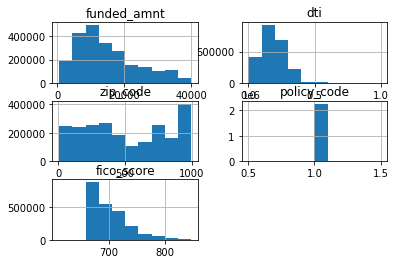

In [515]:
df_accepted_stripped_copy.hist()
plt.show()

### Modifying REJECTED Data Columns

In [503]:
# In case we need to revert back to the old daa
df_rejected_copy = df_rejected.copy()


In [504]:
df_rejected_copy.dtypes

Amount Requested        float64
Application Date         object
Loan Title               object
Risk_Score              float64
Debt-To-Income Ratio     object
Zip Code                 object
State                    object
Employment Length        object
Policy Code             float64
dtype: object

In [505]:
# Changing debt-to-income ratio to float 
df_rejected_copy['Debt-To-Income Ratio'] = df_rejected_copy['Debt-To-Income Ratio'].astype('string')
 
df_rejected_copy['Debt-To-Income Ratio'] = df_rejected_copy['Debt-To-Income Ratio'].str.rstrip('%').astype('float') / 100.0

# Dropping negative dti values and dropping negative and >1 values 
df_rejected_copy = df_rejected_copy[(df_rejected_copy[['Debt-To-Income Ratio']] > 0).all(1)]
df_rejected_copy = df_rejected_copy[(df_rejected_copy[['Debt-To-Income Ratio']] < 1).all(1)]


# Changing settlement date to pd.to_datetime 
df_rejected_copy['Application Date'] = pd.to_datetime(df_rejected_copy['Application Date'])


In [506]:
df_rejected_copy.dtypes

Amount Requested               float64
Application Date        datetime64[ns]
Loan Title                      object
Risk_Score                     float64
Debt-To-Income Ratio           float64
Zip Code                        object
State                           object
Employment Length               object
Policy Code                    float64
dtype: object

In [507]:
df_rejected_copy.head(n = 5)

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,0.1000,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,0.1000,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,0.1000,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,0.3864,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,0.0943,209xx,MD,< 1 year,0.0


# Testing Sample with n = 10,000

In [790]:
# Taking a sample 

sample_rejected = df_rejected_copy.sample(n = 10000, replace = False) 
sample_accepted = df_accepted_stripped_copy.sample(n = 10000, replace = False)

# Adding acceptance indicators 
sample_rejected['accepted'] = 0
sample_accepted['accepted'] = 1


In [791]:
sample_funded_amnt = sample_accepted['funded_amnt'].append(sample_rejected['Amount Requested'])
sample_fico_score = sample_accepted['fico_score'].append(sample_rejected['Risk_Score'])
sample_dti = sample_accepted['dti'].append(sample_rejected['Debt-To-Income Ratio'])
sample_zip_code = sample_accepted['zip_code'].append(sample_rejected['Zip Code'])
sample_addr_state = sample_accepted['addr_state'].append(sample_rejected['State'])
sample_emp_length = sample_accepted['emp_length'].append(sample_rejected['Employment Length'])
sample_policy_code = sample_accepted['policy_code'].append(sample_rejected['Policy Code'])
sample_accept = sample_accepted['accepted'].append(sample_rejected['accepted'])

d = {'funded_amnt' : sample_funded_amnt, 'fico_score' : sample_fico_score, 
    'dti' : sample_dti, 'zip_code' : sample_zip_code, 'addr_state' : sample_addr_state,
    'emp_length' : sample_addr_state, 'emp_length' : sample_emp_length, 
    'policy_code' : sample_policy_code, 'accepted' : sample_accept}

sample_df = pd.DataFrame(data = d)

sample_df.head(n = 3)


,funded_amnt,fico_score,dti,zip_code,addr_state,emp_length,policy_code,accepted
1303242,10000.0,677.0,0.1546,15,MA,3 years,1.0,1
1189910,7500.0,672.0,0.2326,87,NJ,4 years,1.0,1
981328,21000.0,677.0,0.0867,941,CA,10+ years,1.0,1


In [792]:
# Log sample_df
sample_df = sample_df[(sample_df[['funded_amnt']] > 0).all(1)]

sample_df['funded_amnt'] = np.log(sample_df['funded_amnt'])


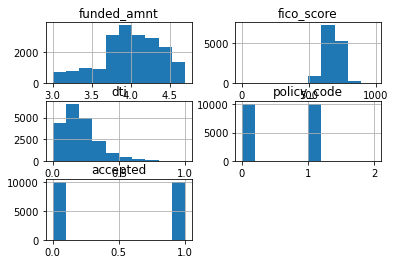

In [793]:
sample_df.hist()

plt.show()



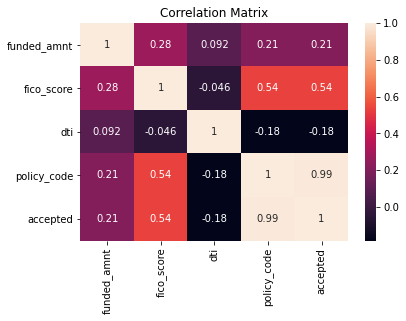

In [794]:
corrMatrix = sample_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix")

plt.show()

In [795]:
# Drop columns that we think would not be necessary 

# Dropping Zip Code since it does not contribute a lot to the correlation matrix 
# compared to the other variables 
sample_df = sample_df.drop(['zip_code'], axis = 1)

# Drop NA values in categorical columns for easier One Hot Encoding 
# I decided to drop since the NA rows in these columns are not alot (n = 33)
sample_df = sample_df.dropna(subset = ["addr_state", "emp_length", 'policy_code'])

sample_df['fico_score'].fillna(np.mean(sample_df['fico_score']), inplace = True)

print(sample_df.isna().sum())
print(sample_df.shape)

funded_amnt    0
fico_score     0
dti            0
addr_state     0
emp_length     0
policy_code    0
accepted       0
dtype: int64
(19008, 7)


### One Hot Encoding

In [796]:
from sklearn.preprocessing import OneHotEncoder

# Implement OneHotEncoding on our categorical variables 
sample_df = pd.get_dummies(sample_df, prefix=['policy_code_'], columns = ['policy_code'])
sample_df = pd.get_dummies(sample_df, prefix = ['state_'], columns = ['addr_state'])
sample_df = pd.get_dummies(sample_df, prefix = ['emp_length_'], columns = ['emp_length'])


sample_df.head(n=3)
# sample_df.columns

,funded_amnt,fico_score,dti,accepted,policy_code__0.0,policy_code__1.0,policy_code__2.0,state__AK,state__AL,state__AR,...,emp_length__10+ years,emp_length__2 years,emp_length__3 years,emp_length__4 years,emp_length__5 years,emp_length__6 years,emp_length__7 years,emp_length__8 years,emp_length__9 years,emp_length__< 1 year
1303242,4.000000,677.0,0.1546,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1189910,3.875061,672.0,0.2326,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
981328,4.322219,677.0,0.0867,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [797]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Split samples 
X = sample_df.drop(['accepted'], axis = 1)
y = sample_df['accepted']

#TEMPORARY: filling fico of rejected by mean 
X.fillna(np.mean(X['fico_score']), inplace = True)

#TODO validation set 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

# Create model 
log_reg = LogisticRegression(max_iter = 400)
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)


In [799]:
log_reg.score(x_test, y_test)


1.0

Confusion matrix:
[[3161    0]
 [   0 3112]]  


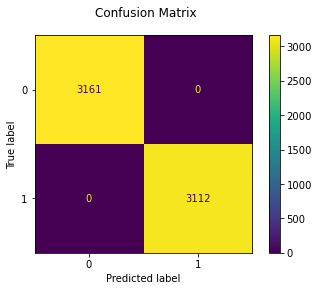

In [800]:
from sklearn import metrics

disp = metrics.plot_confusion_matrix(log_reg, x_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}  ")

plt.show()

In [806]:
# Create list of prob of being accepted for loan 
accepted = []

# Create samples of loan amounts 
requested_amnt = np.linspace(0, 30, 100)

for i in requested_amnt: 
    # Generate a model costumer using the mean values of the features 
    x_model = np.asarray(x_train.mean()[1:])
#     x_model = np.linspace(0,0, 67)
     
    # Insert our proposed loan amount 
    x_model = np.insert(x_model, 0, i)

    acc = np.round(log_reg.predict_proba(x_model.reshape(1,-1))[0][1],5)
    accepted.append(acc)
    

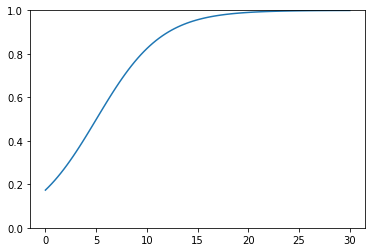

In [807]:
plt.plot(requested_amnt, accepted)
plt.ylim([0,1])

plt.show()




# Using on REAL DATA SET 

IMPORTANT NOTE: We did not use the entire since it was taking way too long for the trainiing to occurr

In [808]:
# Assign data 

# sample_rejected = df_rejected_copy
# sample_accepted = df_accepted_stripped_copy

sample_rejected = df_rejected_copy.sample(n = 500000, replace = False) 
sample_accepted = df_accepted_stripped_copy.sample(n = 500000, replace = False)

# Adding acceptance indicators 
sample_rejected['accepted'] = 0
sample_accepted['accepted'] = 1

In [809]:
# Assign proper columns and combine in one data frame 

sample_funded_amnt = sample_accepted['funded_amnt'].append(sample_rejected['Amount Requested'])
sample_fico_score = sample_accepted['fico_score'].append(sample_rejected['Risk_Score'])
sample_dti = sample_accepted['dti'].append(sample_rejected['Debt-To-Income Ratio'])
sample_zip_code = sample_accepted['zip_code'].append(sample_rejected['Zip Code'])
sample_addr_state = sample_accepted['addr_state'].append(sample_rejected['State'])
sample_emp_length = sample_accepted['emp_length'].append(sample_rejected['Employment Length'])
sample_policy_code = sample_accepted['policy_code'].append(sample_rejected['Policy Code'])
sample_accept = sample_accepted['accepted'].append(sample_rejected['accepted'])

d = {'funded_amnt' : sample_funded_amnt, 'fico_score' : sample_fico_score, 
    'dti' : sample_dti, 'zip_code' : sample_zip_code, 'addr_state' : sample_addr_state,
    'emp_length' : sample_addr_state, 'emp_length' : sample_emp_length, 
    'policy_code' : sample_policy_code, 'accepted' : sample_accept}

sample_df = pd.DataFrame(data = d)



In [810]:
# log our funded_amnt 
sample_df['funded_amnt'] = np.log(sample_df['funded_amnt'])


sample_df.head(n = 3)

,funded_amnt,fico_score,dti,zip_code,addr_state,emp_length,policy_code,accepted
1835230,10.308953,692.0,0.2054,640,MO,10+ years,1.0,1
1682789,8.987197,757.0,0.1310,335,FL,1 year,1.0,1
164524,9.736547,707.0,0.3072,432,OH,10+ years,1.0,1


Note: based on the histogram below seems like our code is okay and we can ignore the warning. It still shows a normal distribution which we desire. 

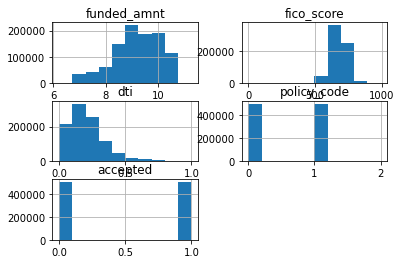

In [811]:
sample_df.hist()
plt.show()

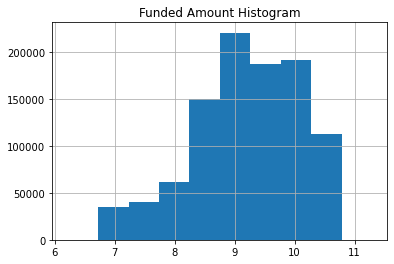

In [812]:
sample_df['funded_amnt'].hist()
plt.title("Funded Amount Histogram")
plt.show()

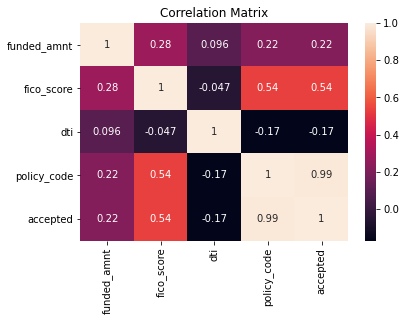

In [813]:
corrMatrix = sample_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix")

plt.show()

In [814]:
# Drop columns that we think would not be necessary 

# Dropping Zip Code since it does not contribute a lot to the correlation matrix 
# compared to the other variables 
sample_df = sample_df.drop(['zip_code'], axis = 1)

# Drop NA values in categorical columns for easier One Hot Encoding 
# I decided to drop since the NA rows in these columns are not alot (n = 33)
# sample_df = sample_df.dropna(subset = ["addr_state", "emp_length", 'policy_code'])
sample_df = sample_df.dropna(subset = ["addr_state", "emp_length"])


print(sample_df.isna().sum())
print(sample_df.shape)

funded_amnt         0
fico_score     308153
dti                 0
addr_state          0
emp_length          0
policy_code        15
accepted            0
dtype: int64
(950773, 7)


In [815]:
from sklearn.preprocessing import OneHotEncoder

# Implement OneHotEncoding on our categorical variables 
# sample_df = pd.get_dummies(sample_df, prefix=['policy_code_'], columns = ['policy_code'])
sample_df = pd.get_dummies(sample_df, prefix = ['state_'], columns = ['addr_state'])
sample_df = pd.get_dummies(sample_df, prefix = ['emp_length_'], columns = ['emp_length'])


# sample_df.head(n=3)
# sample_df.columns

In [816]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Split samples 
X = sample_df.drop(['accepted'], axis = 1)
y = sample_df['accepted']

#Filling fico of rejected by mean 
# The reason for this is that fico score seemed to follow
# normal distribution 
X.fillna(np.mean(X['fico_score']), inplace = True)

# Split sets to training and validation  

x_train_VAL, x_test, y_train_VAL, y_test = train_test_split(X, y, test_size = 0.25)

x_train, x_val, y_train, y_val = train_test_split(x_train_VAL, y_train_VAL, test_size = 0.33)



### Testing on Validation Set 

In [817]:
# Create model for VALIDATION SET 
log_reg_val = LogisticRegression(max_iter = 400)

log_reg_val.fit(x_train, y_train)

y_val_pred = log_reg_val.predict(x_val)



Confusion matrix:
[[118857    449]
 [     0 116011]]  


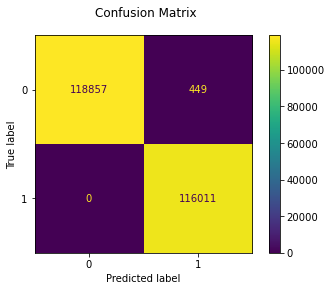

Score 0.9980919355592669


In [818]:
# Evaluate Model Performance 
from sklearn import metrics

disp = metrics.plot_confusion_matrix(log_reg_val, x_val, y_val)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}  ")

plt.show()

print("Score", log_reg_val.score(x_val,y_val))


### Testing on Test Data 

Confusion matrix:
[[120567    413]
 [     0 116714]]  


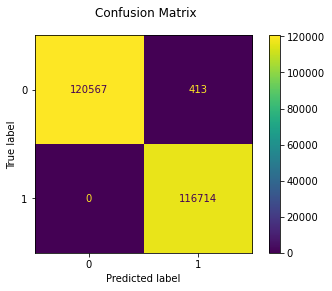

Score 0.9982624719176757


In [819]:
# Create model for VALIDATION SET 
log_reg = LogisticRegression(max_iter = 1000)

log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)

# Evaluate Model Performance 

disp = metrics.plot_confusion_matrix(log_reg, x_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}  ")

plt.show()

print("Score", log_reg.score(x_test,y_test))


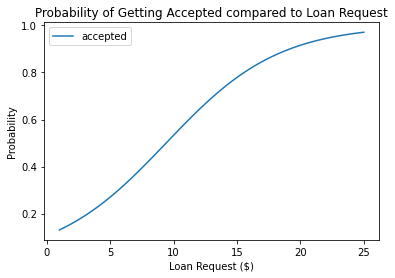

In [845]:
# Create list of prob of being accepted for loan 
accepted = []

# Create samples of loan amounts 
requested_amnt = np.linspace(1, 25, 100)

# rev_requested_amnt= np.exp(requested_amnt)


for i in requested_amnt: 
    # Generate a model costumer using the mean values of the features 
    x_model = np.asarray(x_train.mean()[1:])
    
    # Insert our proposed loan amount 
    x_model = np.insert(x_model, 0, i)

    acc = np.round(log_reg.predict_proba(x_model.reshape(1,-1))[0][1],5)
    accepted.append(acc)
    
plt.plot(requested_amnt, accepted, label = 'accepted')
plt.legend()
plt.title("Probability of Getting Accepted compared to Loan Request")
plt.ylabel("Probability")
plt.xlabel("Loan Request ($)")

plt.show()

In [851]:
np.exp(9.5)

13359.726829661873